# Hybrid network

Simple example showing hybrid spike/rate-coded networks. 

Reproduces Fig.4 of (Vitay, Dinkelbach and Hamker, 2015)

ANNarchy 4.6 (4.6.7b) on linux (posix). 


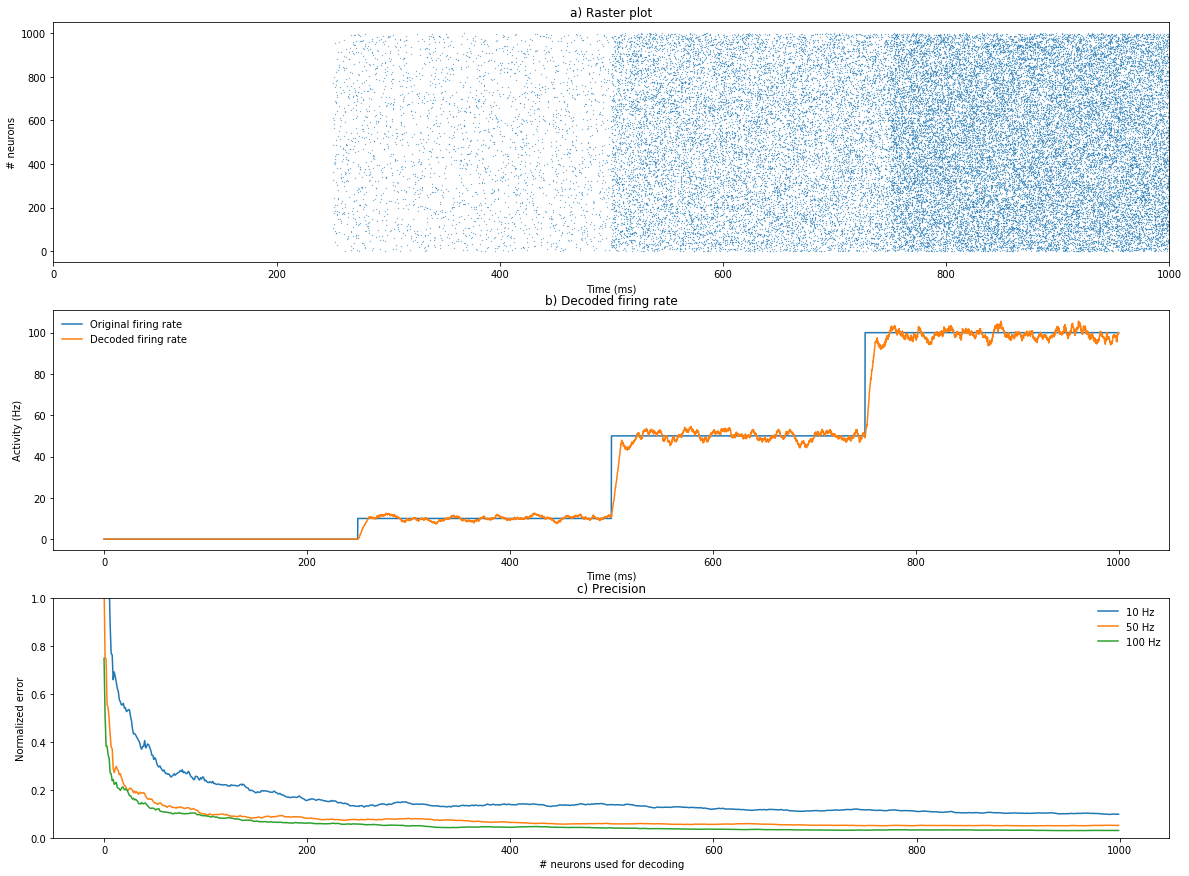

In [1]:
from ANNarchy import *
clear()

setup(dt=0.1)

# Rate-coded input neuron
input_neuron = Neuron(
    parameters = "baseline = 0.0",
    equations = "r = baseline"
)
# Rate-coded output neuron
simple_neuron = Neuron(
    equations = "r = sum(exc)"
)

# Rate-coded population for input
pop1 = Population(geometry=1, neuron=input_neuron)

# Poisson Population to encode
pop2 = PoissonPopulation(geometry=1000, target="exc")
proj = Projection(pop1, pop2, 'exc').connect_all_to_all(weights=1.)

# Rate-coded population to decode
pop3 = Population(geometry=1000, neuron =simple_neuron)
proj = DecodingProjection(pop2, pop3, 'exc', window=10.0)

def diagonal(pre, post, weights):
    """
    Simple connector pattern to progressively connect each post-synaptic neuron to a growing 
    number of pre-synaptic neurons.
    """
    lil = CSR()
    for rk_post in range(post.size):
        lil.add(rk_post, range((rk_post+1)), [weights], [0] )
    return lil
proj.connect_with_func(method=diagonal, weights=1.)

compile()

# Monitors
m1 = Monitor(pop1, 'r')
m2 = Monitor(pop2, 'spike')
m3 = Monitor(pop3, 'r')

# Simulate
duration = 250.
# 0 Hz
pop1.baseline = 0.0
simulate(duration)
# 10 Hz
pop1.baseline = 10.0
simulate(duration)
# 50 Hz
pop1.baseline = 50.0
simulate(duration)
# 100 Hz
pop1.baseline = 100.0
simulate(duration)

# Get recordings
data1 = m1.get()
data2 = m2.get()
data3 = m3.get()

# Raster plot of the spiking population
t, n = m2.raster_plot(data2['spike'])

# Variance of the the decoded firing rate
data_10 = data3['r'][int(1.0*duration/dt()):int(2*duration/dt()), :]
data_50 = data3['r'][int(2.0*duration/dt()):int(3*duration/dt()), :]
data_100 = data3['r'][int(3.0*duration/dt()):int(4*duration/dt()), :]
var_10 = np.mean(np.abs((data_10 - 10.)/10.), axis=0)
var_50 = np.mean(np.abs((data_50 - 50.)/50.), axis=0)
var_100 = np.mean(np.abs((data_100 - 100.)/100.), axis=0)

### Plot the results
% matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)

plt.subplot(3,1,1)
plt.plot(t, n, '.', markersize=0.5)
plt.title('a) Raster plot')
plt.xlabel('Time (ms)')
plt.ylabel('# neurons')
plt.xlim((0, 4*duration))

plt.subplot(3,1,2)
plt.plot(np.arange(0, 4*duration, 0.1), data1['r'][:, 0], label='Original firing rate')
plt.plot(np.arange(0, 4*duration, 0.1), data3['r'][:, 999], label='Decoded firing rate')
plt.legend(frameon=False, loc=2)
plt.title('b) Decoded firing rate')
plt.xlabel('Time (ms)')
plt.ylabel('Activity (Hz)')

plt.subplot(3,1,3)
plt.plot(var_10, label='10 Hz')
plt.plot(var_50, label='50 Hz')
plt.plot(var_100, label='100 Hz')
plt.legend(frameon=False)
plt.title('c) Precision')
plt.xlabel('# neurons used for decoding')
plt.ylabel('Normalized error')
plt.ylim((0,1))

plt.show()